In [1]:
import os
import io
import sys
import json
import pickle
import fasttext
import numpy as np
import pandas as pd
from plotnine import *
from gensim.models import keyedvectors
from collections import Counter
from scipy.spatial.distance import cosine
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize.regexp import RegexpTokenizer

stops = set(stopwords.words('english'))
tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
pd.options.plotting.backend = "plotly"

## Import

### Commoncrawl

In [2]:
DOWNLOAD_FOLDER = os.path.join(os.path.expanduser('~'), "Projects", "news-please", "cc_download_articles")
articles = []
folders = os.listdir(DOWNLOAD_FOLDER)
for folder in folders:
    if os.path.isdir(os.path.join(DOWNLOAD_FOLDER, folder)):
        for article_f in os.listdir(os.path.join(DOWNLOAD_FOLDER, folder)):
            with open(os.path.join(DOWNLOAD_FOLDER, folder, article_f)) as f:
                articles.append(json.load(f))


In [4]:
cc_df = pd.DataFrame(articles)
cc_df = cc_df.rename(
    columns={
        "title": "article_title",
        "maintext": "article_text",
        "date_publish": "article_publish_date",
        "description": "article_summary",
        "url" : "source_link"
    }
)

In [5]:
# cc_df.to_excel(
#     os.path.join(
#         os.path.dirname(os.path.abspath("__file__")),
#         os.pardir,
#         "data",
#         "processed",
#         "cc_news.xlsx",
#     ),
#     index=False,
# )


In [6]:
# cc_df = pd.read_excel(
#     os.path.join(
#         os.path.dirname(os.path.abspath("__file__")),
#         os.pardir,
#         "data",
#         "processed",
#         "cc_news.xlsx",
#     )
# )


### Reddit and NASA

In [8]:
DATA_PATH = os.path.join(
    os.path.dirname(os.path.abspath("__file__")), os.pardir, "data", "reddit"
)

MODEL_PATH = os.path.join(
    os.path.dirname(os.path.abspath("__file__")), os.pardir, "models"
)

reddit_articles_df = pd.read_csv(
    os.path.join(DATA_PATH, "all_valid_articles.csv"), sep="\t"
)
nasa_articles_df = pd.read_csv(
    os.path.join(DATA_PATH, "filtered_text_pre.csv"), index_col=0
)
nasa_articles_df = nasa_articles_df.rename(
    columns={
        "titles": "article_title",
        "text": "article_text",
        "dates": "article_publish_date",
        "summary": "article_summary",
        "links": "source_link",
    }
)

# tagged_articles_df = pd.read_csv()


## Filter

In [9]:
POSITIVE_LEXICON = [
    "landslide",
    "landslides",
    "mudslide",
    "mudslides",
    "slope failure",
    "debris flow",
    "mass wasting",
    "rockfall",
    "rockfalls",
    "rockslide",
    "rockslides",
    "rock-slide",
    "rock-slides",
    "ground failure",
    "slope erosion",
    "landslip",
    "landslips",
    "mudflow",
    "mudflows",
]


NEGATIVE_LEXICON = [
    "politics",
    "election",
    "political",
    "defeat",
    "victory",
    "campain",
    "music",
    "caught in a landside"
]


def is_landslide_keyword_in_article(article):
    return any([keyword in article["article_text"] for keyword in POSITIVE_LEXICON])


def is_no_not_landslide_keyword_in_article(article):
    return not any([keyword in article["article_text"] for keyword in NEGATIVE_LEXICON])


def is_n_landslide_keyword_in_article(article, n=3):
    return (
        sum([article["text"].lower().count(keyword) for keyword in POSITIVE_LEXICON])
        >= n
    )


def filter_articles_by_lang(df, lang="en"):
    lang_model = fasttext.load_model(os.path.join(MODEL_PATH, "lid.176.bin"))
    pred, prob = lang_model.predict(
        df["text"].str.replace("\n", " ").to_numpy().tolist()
    )
    df["lang"] = np.array(pred).squeeze(axis=-1)
    df["lang"] = df["lang"].str.replace("__label__", "")

    return df[df["lang"] == lang]


def filter_articles(df):
    df = df.dropna(subset=["article_title", "article_text"]).copy()
    df["sub_text"] = (
        df["article_text"].str.slice(stop=500).str.lower().str.replace("\n", " ")
    )
    df = df.drop_duplicates(subset=["sub_text"]).copy()
    df["text"] = df.apply(
        lambda x: x["article_title"] + "\n" + x["article_text"], axis=1
    )
    df = df[df.apply(is_landslide_keyword_in_article, axis=1)]
    df = df[df.apply(is_no_not_landslide_keyword_in_article, axis=1)]
    df = filter_articles_by_lang(df)
    return df


In [10]:
nasa_filtered_df = filter_articles(nasa_articles_df)
reddit_filtered_df = filter_articles(reddit_articles_df)
cc_filtered_df = filter_articles(cc_df)

In [11]:
print(nasa_articles_df.shape)
print(reddit_articles_df.shape)
print(cc_df.shape)

print(nasa_filtered_df.shape)
print(reddit_filtered_df.shape)
print(cc_filtered_df.shape)

(5410, 8)
(3788, 20)
(135896, 15)
(3169, 11)
(2085, 22)
(28293, 18)


In [12]:
counter = Counter(
    [
        token
        for doc in [tokenizer.tokenize(doc.lower()) for doc in nasa_filtered_df["text"].to_numpy()]
        for token in doc
        if token not in stops
        and token.isalpha()
    ]
)
counter.most_common(20)

[('said', 8822),
 ('landslide', 6714),
 ('road', 5420),
 ('people', 3210),
 ('area', 2957),
 ('landslides', 2830),
 ('rain', 2693),
 ('highway', 2500),
 ('heavy', 2484),
 ('also', 2303),
 ('two', 2232),
 ('water', 2164),
 ('one', 2145),
 ('debris', 1867),
 ('near', 1866),
 ('closed', 1857),
 ('due', 1779),
 ('mudslide', 1657),
 ('rains', 1648),
 ('city', 1645)]

In [13]:
counter = Counter(
    [
        token
        for doc in [tokenizer.tokenize(doc.lower()) for doc in reddit_filtered_df["text"].to_numpy()]
        for token in doc
        if token not in stops
        and token.isalpha()
    ]
)
counter.most_common(20)

[('said', 8060),
 ('people', 4993),
 ('landslide', 4883),
 ('landslides', 3199),
 ('heavy', 2282),
 ('rain', 2158),
 ('area', 2120),
 ('state', 1893),
 ('also', 1735),
 ('two', 1703),
 ('one', 1667),
 ('rains', 1628),
 ('water', 1570),
 ('road', 1569),
 ('rescue', 1546),
 ('missing', 1533),
 ('least', 1527),
 ('highway', 1408),
 ('areas', 1407),
 ('flooding', 1402)]

In [14]:
counter = Counter(
    [
        token
        for doc in [tokenizer.tokenize(doc.lower()) for doc in cc_filtered_df["text"].to_numpy()]
        for token in doc
        if token not in stops
        and token.isalpha()
    ]
)
counter.most_common(20)

[('said', 88931),
 ('people', 57960),
 ('also', 32949),
 ('water', 26785),
 ('heavy', 26361),
 ('one', 26218),
 ('storm', 26061),
 ('rain', 25485),
 ('landslides', 24235),
 ('areas', 23577),
 ('state', 22192),
 ('flooding', 21989),
 ('two', 21516),
 ('area', 21502),
 ('landslide', 20676),
 ('floods', 19492),
 ('weather', 18468),
 ('new', 17946),
 ('disaster', 17784),
 ('could', 17752)]

## Detect

In [15]:
import gensim.downloader as api
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from gensim.matutils import corpus2csc, cossim, any2sparse

In [16]:
def preprocess(sent):
    tokens = tokenizer.tokenize(sent)
    return [
        token.lower()
        for token in tokens
        if len(token) > 2 and token.isalpha() and token.lower() not in stops
    ]


def vectorizer(text):
    return model[dct.doc2bow(preprocess(text))]


def get_article_similarity_score(article, vectorizer, tfidf_landslide_vector):
    article_vector = vectorizer(article["text"])
    return cossim(tfidf_landslide_vector, article_vector)


In [17]:
nasa_corpus = [preprocess(sent) for sent in nasa_filtered_df["text"].to_numpy()]
reddit_corpus = [preprocess(sent) for sent in reddit_filtered_df["text"].to_numpy()]
cc_corpus = [preprocess(sent) for sent in cc_filtered_df["text"].to_numpy()]

In [18]:
dct = Dictionary(cc_corpus)
dct.filter_extremes(keep_n=50_000)

nasa_vec_corpus = [dct.doc2bow(doc) for doc in nasa_corpus]
reddit_vec_corpus = [dct.doc2bow(doc) for doc in reddit_corpus]
cc_vec_corpus = [dct.doc2bow(doc) for doc in cc_corpus]

In [19]:
model = TfidfModel(cc_vec_corpus, dictionary=dct, smartirs="ttb")

In [20]:
nasa_corpus_article_lengths = np.array([len(a) for a in nasa_vec_corpus])

In [21]:
ncal_df = pd.DataFrame({"len" : nasa_corpus_article_lengths})

In [22]:
ncal_df.describe()

,len
count,3169.000000
mean,105.412749
std,83.463985
min,6.000000
25%,55.000000
50%,86.000000
75%,131.000000
max,1900.000000


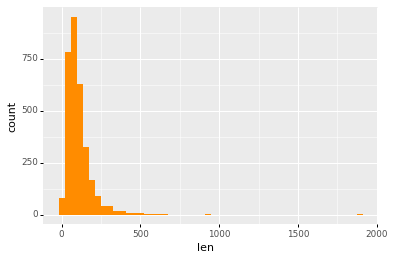

<ggplot: (721952287)>

In [23]:
(
    ggplot(ncal_df, aes(x="len")) +
    geom_histogram(bins=50, fill="darkorange") +
    theme_gray()
)

In [24]:
article_length_threshold = 100
tc = model[[a for a in nasa_vec_corpus if len(a) < article_length_threshold]]

nasa_csc_vecs = corpus2csc(tc)

nasa_csc_avg_vec = nasa_csc_vecs.mean(axis=1)
nasa_csc_avg_vec = np.array(nasa_csc_avg_vec).squeeze()

nasa_tfidf_vec = any2sparse(nasa_csc_avg_vec)

In [25]:
top_words = nasa_csc_avg_vec.argsort()[::-1][:40]
[dct.id2token[id] for id in top_words]

['landslide',
 'road',
 'highway',
 'mudslide',
 'traffic',
 'closed',
 'slide',
 'police',
 'district',
 'county',
 'blocked',
 'village',
 'killed',
 'occurred',
 'near',
 'landslip',
 'lane',
 'route',
 'buried',
 'area',
 'incident',
 'morning',
 'debris',
 'injured',
 'heavy',
 'rain',
 'rains',
 'due',
 'reported',
 'china',
 'train',
 'house',
 'crews',
 'railway',
 'two',
 'triggered',
 'rockslide',
 'cleared',
 'houses',
 'mud']

In [26]:
def preprocess(sent):
    tokens = tokenizer.tokenize(sent)
    return [
        token.lower()
        for token in tokens
        if len(token) > 2 and token.isalpha() and token.lower() not in stops
    ]


def vectorizer(text, model, dct):
    return model[dct.doc2bow(preprocess(text))]


def get_article_similarity_score(article, tfidf_landslide_vector, model, dct):
    article_vector = vectorizer(article["text"], model, dct)
    return cossim(tfidf_landslide_vector, article_vector)


In [27]:
nasa_filtered_df["similarity"] = nasa_filtered_df.apply(
    get_article_similarity_score,
    tfidf_landslide_vector=nasa_tfidf_vec,
    model = model,
    dct = dct,
    axis=1,
)

reddit_filtered_df["similarity"] = reddit_filtered_df.apply(
    get_article_similarity_score,
    tfidf_landslide_vector=nasa_tfidf_vec,
    model = model,
    dct = dct,
    axis=1,
)

cc_filtered_df["similarity"] = cc_filtered_df.apply(
    get_article_similarity_score,
    tfidf_landslide_vector=nasa_tfidf_vec,
    model = model,
    dct = dct,
    axis=1
)

In [28]:
threshold = 0.08

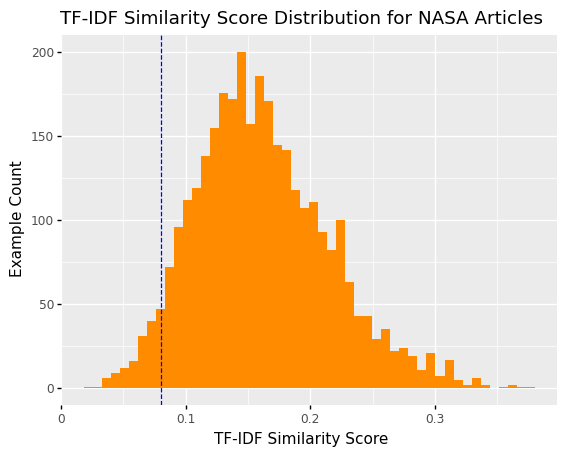

<ggplot: (903970253)>

In [29]:
(
    ggplot(nasa_filtered_df, aes(x="similarity")) +
    geom_histogram(bins=50, fill="darkorange") +
    geom_vline(xintercept = threshold, color="blue", linetype="dashed") +
    ggtitle("TF-IDF Similarity Score Distribution for NASA Articles") +
    ylab("Example Count") +
    xlab("TF-IDF Similarity Score") +
    theme_gray()
)

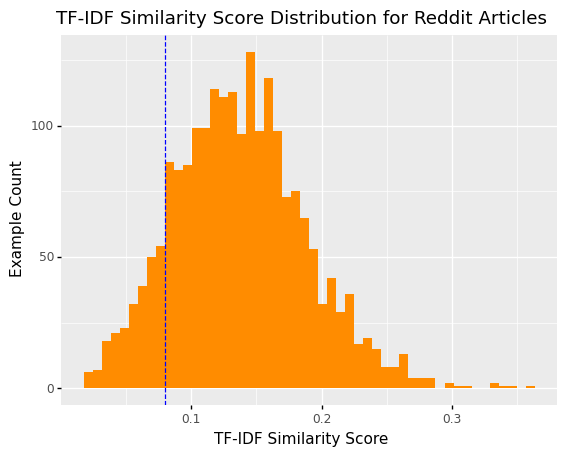

<ggplot: (905423722)>

In [30]:
(
    ggplot(reddit_filtered_df, aes(x="similarity")) +
    geom_histogram(bins=50, fill="darkorange") +
    geom_vline(xintercept = threshold, color="blue", linetype="dashed") +
    ggtitle("TF-IDF Similarity Score Distribution for Reddit Articles") +
    ylab("Example Count") +
    xlab("TF-IDF Similarity Score") +
    theme_gray()
)

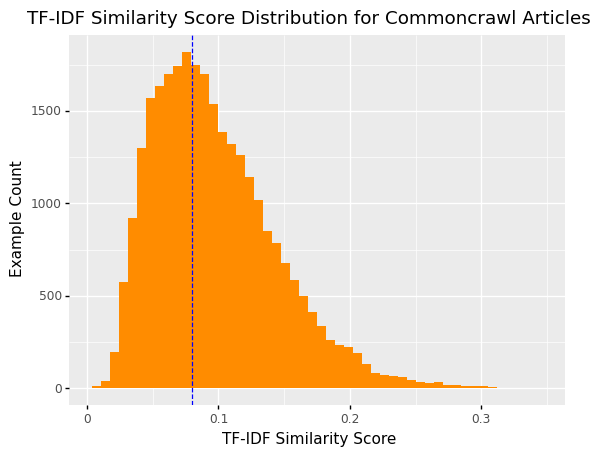

<ggplot: (912622608)>

In [31]:
(
    ggplot(cc_filtered_df, aes(x="similarity")) +
    geom_histogram(bins=50, fill="darkorange") +
    geom_vline(xintercept = threshold, color="blue", linetype="dashed") +
    ggtitle("TF-IDF Similarity Score Distribution for Commoncrawl Articles") +
    ylab("Example Count") +
    xlab("TF-IDF Similarity Score") +
    theme_gray()
)

In [32]:
print(cc_filtered_df.sort_values(by="similarity")["article_title"].iloc[:20].to_numpy())


["'Game changer' map reveals precious UK landmarks most"
 'Island Slipper: Limited Edition Ala Moana Center 60th Anniversary Slipper'
 'Island Slipper: Classy Collection'
 'Rappers And Influencers Embrace NFTs At Tory Lanez BET After Party, Hosted By YAAAS and DaBaby, Megan Thee Stallion quarrel over Tory Lanez Retweet'
 'Island Slipper: Imperial Collection' 'Island Slipper: Suede Collection'
 'Kylie Hoylman of The Dalles named one of state’s best point guards'
 'Manhoef or Bahati, Carvalho or Nemkov?'
 'Hurricane Elsa Moving Quickly Toward Haiti, Dominican'
 'Hurricane Elsa races toward Haiti amid fears of'
 'Tropical Storm Fred nears Dominican'
 'Demon emerges out of Glenwood Cañon, claims I-70 as his own'
 'Scientists roll orbs down mountains in rockfall experiment'
 'Reese Kaplan -- What You See in 2019 is What Yo...'
 'Island Slipper Collaboration with Pacific Whale Foundation'
 'Island Slipper Elegant Flower Collection'
 'Island Slipper: Da Hawaiian Collection'
 'MHTC sales tax p

In [33]:
print(cc_filtered_df.sort_values(by="similarity")["article_title"].iloc[-20:].to_numpy())

['Jammu-Srinagar highway closed after snow, landslides'
 'Srinagar-Jammu highway closed again, Leh, Mughal roads still shut'
 'Snow, landslides lead to closure of Jammu-Srinagar National Highway'
 'One-way traffic resumes on Srinagar-Jammu highway, Leh, Mughal roads shut'
 'Nahan-Kumarhatti road blocked on National Highway 907 following a massive landslide yesterday'
 'Another body pulled out, death toll in landslide on J-K highway climbs to two'
 'Srinagar-Jammu highway remains closed for 2nd day'
 'Srinagar-Jammu highway closed for second day'
 'Efforts on to restore Jammu-Srinagar highway, fresh snowfall predicted'
 'Jammu-Srinagar highway closed due to landslide in Ramban, 3,000 vehicles stranded'
 'Jammu-Srinagar National Highway closed for the third day; more than 250 authorized stranded vehicles'
 'Srinagar-Leh highway remains closed for 2nd day'
 'Jammu-Srinagar highway closed due to landslide in Ramban'
 'Landslide on highway disrupts traffic for 4 hours'
 'ROAD CLOSURES: Full

In [34]:
cc_filtered_df.sort_values(by="similarity")["text"].iloc[
    :1000
].str.len().to_numpy().mean()


2816.695

In [35]:
cc_filtered_df.sort_values(by="similarity")["text"].iloc[
    -1000:
].str.len().to_numpy().mean()


3027.461

In [36]:
cc_filtered_df.sort_values(by="similarity")["text"].iloc[
    :100
].str.len().to_numpy().mean()


1924.59

In [37]:
cc_filtered_df.sort_values(by="similarity")["text"].iloc[
    -100:
].str.len().to_numpy().mean()


2269.6

#### Saving

In [253]:
model.save(os.path.join(MODEL_PATH, "landslide_tfidf.model"))

In [263]:
with open(os.path.join(MODEL_PATH, "landslide_tfidf.vec"), "wb") as f:
    pickle.dump(nasa_tfidf_vec, f)

In [264]:
dct.save_as_text(os.path.join(MODEL_PATH, "dictionary.txt"))